# CNN Model Template

This notebook is a template for building a CNN model.

## Imports and inital setup

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras import backend as K
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC, Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

from time import sleep 

import sys
import os

sys.path.append("..")
from helperfunctions import modelhelper as mh
from helperfunctions import imagehelper as ih

SEED = 856
NUM_EPOCHS = 40

# File path variables
# please make sure to use the correct path to the meta data file

FILEPATH_JPGS = './../data/jpgs/'
FILEPATH_PROCESSED="./../data/processed/"
FILEPATH_OUTPUT = './../data/jpgs/'  # Replace with your folder path

TARGET_LABEL="dx_tertiary"

IMAGE_SIZE = (224, 224)

### Loading (augmented) metadata as test, train, validation from files

In [2]:
# Read the metadata file
train_df = pd.read_csv(FILEPATH_PROCESSED+"train_from_Metadata_processed.csv")
validation_df = pd.read_csv(FILEPATH_PROCESSED+"validation_from_Metadata_processed.csv")
test_df = pd.read_csv(FILEPATH_PROCESSED+"test_from_Metadata_processed.csv")

train_df.sample(15)

,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,dx_binary,dx_tertiary,image_path
3674,HAM_0005971,aug_6aDLQDISIC_0024452.jpg,bcc,histo,40.0,male,back,rosendahl,skin_cancer,malignant,./../data/jpgs/aug_6aDLQDISIC_0024452.jpg
1300,HAM_0001772,ISIC_0033270.jpg,bkl,consensus,85.0,male,back,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/ISIC_0033270.jpg
1718,HAM_0002771,ISIC_0029059.jpg,akiec,histo,80.0,female,lower extremity,rosendahl,skin_cancer,malignant,./../data/jpgs/ISIC_0029059.jpg
5057,HAM_0002450,aug_rpDinnISIC_0024318.jpg,df,consensus,65.0,female,lower extremity,vidir_modern,not_skin_cancer,non-neoplastic,./../data/jpgs/aug_rpDinnISIC_0024318.jpg
15,HAM_0003896,ISIC_0030952.jpg,nv,follow_up,35.0,male,abdomen,vidir_molemax,not_skin_cancer,benign,./../data/jpgs/ISIC_0030952.jpg
2249,HAM_0006220,aug_DLcLN6ISIC_0028517.jpg,akiec,histo,60.0,male,upper extremity,rosendahl,skin_cancer,malignant,./../data/jpgs/aug_DLcLN6ISIC_0028517.jpg
1591,HAM_0001258,ISIC_0025331.jpg,akiec,histo,80.0,male,face,rosendahl,skin_cancer,malignant,./../data/jpgs/ISIC_0025331.jpg
3532,HAM_0003046,aug_mKlM21ISIC_0033257.jpg,bcc,histo,70.0,male,face,vidir_modern,skin_cancer,malignant,./../data/jpgs/aug_mKlM21ISIC_0033257.jpg
1802,HAM_0003401,aug_Y84p58ISIC_0029598.jpg,akiec,histo,55.0,male,face,rosendahl,skin_cancer,malignant,./../data/jpgs/aug_Y84p58ISIC_0029598.jpg
2470,HAM_0006545,ISIC_0032598.jpg,mel,histo,50.0,female,back,vidir_modern,skin_cancer,malignant,./../data/jpgs/ISIC_0032598.jpg


## Setting up the image data generator for training and validation

In [3]:
def custom_preprocessing(np_image, image_size):
    # print the image
    print("Image shape before preprocessing:", np_image.shape)
    plt.imshow(np_image)
    plt.show()
    np_image = ih.center_crop_image(np_image) # Crop image to square format
    print("Image shape after center crop:", np_image.shape)
    plt.imshow(np_image)
    plt.show()
    np_image = ih.resize_as_preprocess(np_image, image_size) # resize the image
    print("Image shape after preprocessing:", np_image.shape)
    plt.imshow(np_image)
    plt.show()
    
    sleep(100)
    return np_image

In [4]:
# print("sample aug image after preprocessing:")
# sample_img_path = "./../data/jpgs/aug_s8yXnVISIC_0030555.jpg"
# sample_img = plt.imread(sample_img_path)


# processed_img = custom_preprocessing(sample_img, IMAGE_SIZE) 

# print("sample orig image after preprocessing:")
# sample_img_path = "./../data/jpgs/ISIC_0030571.jpg"
# sample_img = plt.imread(sample_img_path)
# processed_img = custom_preprocessing(sample_img, IMAGE_SIZE) 

# plt.imshow(processed_img)
# plt.show()

In [5]:
# Setting up the Image Data Generator for the train data set

datagen_train = ImageDataGenerator(
    rescale=1.0 / 255.0, 
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE), # Apply the custom preprocessing function 
)

datagen_validation = ImageDataGenerator(
    rescale=1.0 / 255.0,
    preprocessing_function=lambda x: custom_preprocessing(x, IMAGE_SIZE)
)

validation_generator = datagen_validation.flow_from_dataframe(
    dataframe=validation_df,
    directory=FILEPATH_JPGS,
    x_col="image_id",
    y_col=TARGET_LABEL,
    class_mode="categorical",
    target_size=IMAGE_SIZE,
    batch_size=32
)

train_data_generator = datagen_train.flow_from_dataframe(
        dataframe=train_df,
        directory=FILEPATH_JPGS,
        x_col="image_id",
        y_col=TARGET_LABEL,
        class_mode="categorical",
        target_size=IMAGE_SIZE,
        batch_size=32
)

Found 1001 validated image filenames belonging to 3 classes.
Found 5254 validated image filenames belonging to 3 classes.


# Using MobileNet V3 large

In [6]:
def f1_score(y_true, y_pred):
    # Calculate precision
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())

    # Calculate recall
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())

    # Calculate F1 score
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [7]:
def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon())) \
               -K.sum((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    return focal_loss_fixed

In [8]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=0.00001)

In [9]:
PRETRAINED = True

if PRETRAINED:
    # Initialize the MobileNetV3Large model
    base_model = MobileNetV3Large(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    print(base_model.output_shape)

    # Freeze the base model's layers to use it for feature extraction
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom layers on top 
    x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu')(base_model.output)

    x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu')(x)

    # Global average pooling instead of flattening
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dense(128, activation='relu')(x)

    x = layers.Dropout(0.5)(x)  # 50% dropout /new

    x = layers.Dense(train_df[TARGET_LABEL].nunique(), activation='softmax')(x) 

    # Create the full model
    model = Model(inputs=base_model.input, outputs=x, name="MobilneNetV3Large_pretrained-weights_binary_fixed-layers_custom-conv2D")

    # Setting an optimizer
    opt = SGD(learning_rate=0.0001, 
                momentum=0.9
                # nesterov=True,
                # decay=0.01
              )

    # Compile the model
    model.compile(optimizer=opt,
                loss='categorical_crossentropy',
                #loss = focal_loss(),
                metrics=[
                        #Recall(), 
                        #Precision(), 
                        'accuracy',
                        f1_score
                        ])

    model.summary()

else:
    # Initialize the MobileNetV3Large model
    base_model = MobileNetV3Large(weights=None, include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

    # Freeze the base model's layers to use it for feature extraction
    for layer in base_model.layers:
        layer.trainable = True

    # Add custom layers on top 
    x = layers.Flatten()(base_model.output)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(train_df[TARGET_LABEL].nunique(), activation='sigmoid')(x) 

    # Create the full model
    model = Model(inputs=base_model.input, outputs=x, name="MobilneNetV3Large_rand-weights")


    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
            loss='binary_crossentropy',
            metrics=['accuracy'])

    model.summary()


(None, 7, 7, 960)
Model: "MobilneNetV3Large_pretrained-weights_binary_fixed-layers_custom-conv2D"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 112, 112, 16)         432       ['rescaling[0][0]']           
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 112, 112, 16)         64        ['Conv[0][0]']                
 lization) 

## Model Training

In [10]:
import matplotlib.pyplot as plt

class ImageDisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, generator, num_samples=5):
        super(ImageDisplayCallback, self).__init__()
        self.generator = generator
        self.num_samples = num_samples

    def on_epoch_begin(self, epoch, logs=None):
        # Get a batch of images and labels
        images, _ = next(self.generator)


        # Display the first few images from the batch
        for i in range(min(self.num_samples, len(images))):
            #plt.imshow(images[i][:, :, ::-1] * 255)  # This will flip the channels
            img = np.clip(images[i]*255, 0, 255).astype('uint8')
            plt.imshow(img)
            plt.title(f"Sample {i+1} at Epoch {epoch+1}")
            plt.axis('off')
            plt.show()


In [11]:
# from tensorflow.keras.preprocessing import image

# # Load image from disk
# img_path = "path_to_image.jpg"
# img_disk = image.load_img(img_path, target_size=(img_height, img_width))
# img_disk_array = image.img_to_array(img_disk)

# # Get image from generator
# img_gen_array, _ = next(generator)

# # Compare the two arrays
# is_same = np.array_equal(img_disk_array, img_gen_array[0])  # Assuming you're comparing the first image in the batch


In [12]:
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.callbacks import Callback

class ImageComparisonCallback(Callback):
    def __init__(self, generator, base_dir):
        super(ImageComparisonCallback, self).__init__()
        self.generator = generator
        self.base_dir = base_dir

    def on_epoch_begin(self, epoch, logs=None):
        # Extract the filename of the first image from the generator's current batch
        idx = (self.generator.batch_index - 1) * self.generator.batch_size
        filename = self.generator.filenames[idx]

        # Construct the complete path
        img_path = os.path.join(self.base_dir, filename)

        # Load image from disk
        img_disk = image.load_img(img_path, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1]))
        img_disk_array = image.img_to_array(img_disk)

        # Get image from generator
        img_gen_array, _ = next(self.generator)

        # Compare the two arrays
        is_same = np.array_equal(img_disk_array, img_gen_array[0])  # Comparing the first image in the batch
        if is_same:
            print("The images are identical!")
        else:
            print("The images are different!")

        # Display both images for comparison
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))
        axes[0].imshow(img_disk_array.astype('uint8'))
        axes[0].set_title('Image from Disk')
        axes[0].axis('off')
        
        axes[1].imshow((img_gen_array[0]*255).astype('uint8'))
        axes[1].set_title('Image from Generator')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

# Usage:
base_dir = FILEPATH_JPGS



In [13]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(datagen_train )

AttributeError: 'ImageDataGenerator' object has no attribute 'class_indices'

Image shape before preprocessing: (224, 224, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


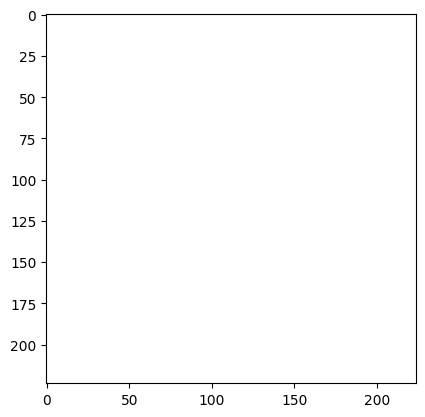

trying 1
255.0
30.0
error, 1 didn't work
trying L
255.0
30.0
error, L didn't work
trying P
255.0
30.0
error, P didn't work
trying RGB
255.0
30.0
error, RGB didn't work
trying RGBA
255.0
30.0


In [13]:
# Train the model

history = model.fit(
    train_data_generator,
    epochs=NUM_EPOCHS,              
    verbose=1,                      # Adjust verbosity level
    batch_size=None,                # Set the batch size, default is 32, can be increased to speed up training
    callbacks=[reduce_lr, ImageComparisonCallback(generator=train_data_generator, base_dir=base_dir)],                 # List of callbacks to apply during training 
    validation_split=0.0,           # not needed as we use a validation data generator
    validation_data=validation_generator,
    shuffle=True,                   # Shuffle the training data before each epoch
    sample_weight=None,             # Set the weights for the train data set !
    class_weight=None,              # Set the weights for the classes, not needed if we use sample weights
    initial_epoch=0,                # Use this to continue training from a specific epoch
    steps_per_epoch=None,           # Set the number of steps per epoch, default is len(x_train) // batch_size
    validation_steps=None,          # Set the number of steps for validation, default is len(x_val) // batch_size
    validation_batch_size=None,     # Set the batch size for validation, default is batch_size
    validation_freq=1,              # Only relevant if validation data is a generator. Set the frequency to validate the model on the validation set
    max_queue_size=10,              # Set the max size for the generator queue
    workers=-1,                     # Set the max number of processes to generate the data in parallel, -1 means all CPUs
    use_multiprocessing=False       # Set to True if you use a generator in parallel, e.g. model.predict_generator()
)

## Plotting accuracy and loss of train and validation set

In [ ]:
# mh.model_plot_accuracy(history)

## Evaluating the model on the test set

 > Evaluating model MobilneNetV3Large_pretrained-weights_binary_fixed-layers_custom-conv2D:
 > Loading test images...
 > Test images loaded.


 > Converting labels to one hot format...
 > Getting model predictions...
32/32 [==============================] - 7s 192ms/step
 > Model predictions obtained.
 > Macro AUC: 0.4158456385168335
 > Micro AUC: 0.23261809713905524


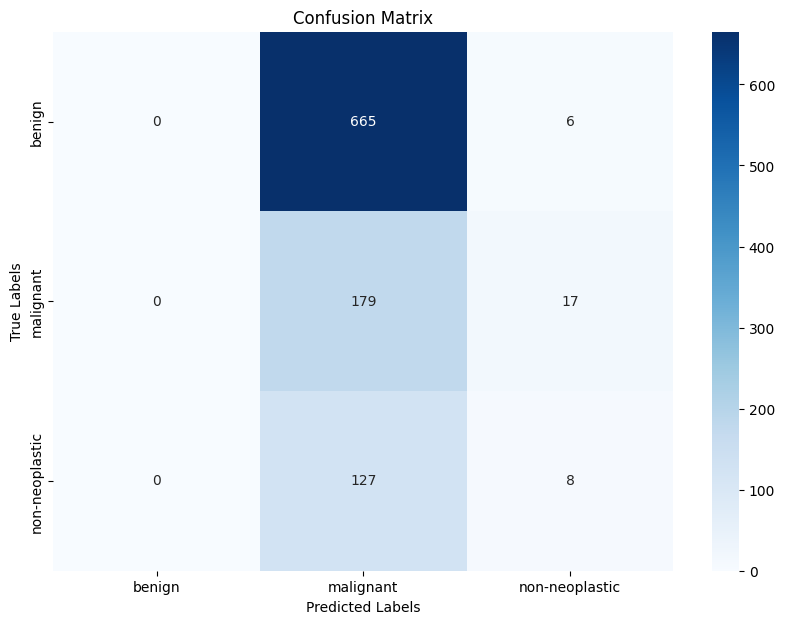



 > Computing classification report...
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       671
           1       0.18      0.91      0.31       196
           2       0.26      0.06      0.10       135

    accuracy                           0.19      1002
   macro avg       0.15      0.32      0.13      1002
weighted avg       0.07      0.19      0.07      1002

 > Evaluating model on test set...


/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

32/32 [==============================] - 6s 192ms/step - loss: 1.5550 - accuracy: 0.1866 - f1_score: 0.0000e+00
loss: 1.5550085306167603
accuracy: 0.18662674725055695
f1_score: 0.0
 > Done.


([{'loss': 1.5550085306167603},
  {'accuracy': 0.18662674725055695},
  {'f1_score': 0.0}],
 array([[  0, 665,   6],
        [  0, 179,  17],
        [  0, 127,   8]]),
 (0.23261809713905524, 0.4158456385168335))

In [ ]:
mh.model_accuracy_on_test(model, test_df, TARGET_LABEL, IMAGE_SIZE)

## Saving the model

In [ ]:
from datetime import datetime
timestamp = datetime.now()
model_path = f"../models/model_{timestamp}.h5"
model.save(model_path)

/Users/stefanberkenhoff/code/capstone-healthy-skin/.venv/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
